In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import h5py
import copy
import json
%matplotlib inline
%load_ext line_profiler

In [2]:
class Cell():
    def __init__(self, cell_id, x, y):
        self.cell_id = cell_id
        self.x = x
        self.y = y
        self.is_occupied = False
        self.next_cell = None
        self.root = self
        self.spanning_vector = None
 
    def get_coordinates(self):
        return (self.x, self.y)

    def get_root(self):
        if self.root == self:
            return self
        else:
            root = self.root
            while root != root.get_root():
                root = root.get_root()
            else:
                return root
   
    def set_root(self, root):
        self.root = root
    
    def set_next(self, other):
        if self.get_next_cell() == self:
            self.next_cell = other
        else:
            cell = self
            path = [other]
            while cell.get_next_cell() != cell:
                path.append(cell)
                cell = cell.get_next_cell()
            else:
                path.append(cell)
            for i in range(len(path) - 1):
                path[-(i + 1)].next_cell = path[-(i+2)]
        
    def get_next_cell(self):
        if self.next_cell:
            return self.next_cell
        else:
            return self
        
    
    def occupy_cell(self):
        self.is_occupied = True
    
    def compress_path(self, root):
        # redirect cell's root to new root
        if self.get_root() != self:
            self.get_root().set_root(root)
        
        # now set original cell's root
        self.set_root(root)
        
        # now set root of all cells that are linked to original cell
        cell = self
        while cell.next_cell:
            if cell.next_cell.get_root() == root:
                break
            cell.next_cell.set_root(root)
            cell = cell.next_cell
        else:
            cell.set_root(root)
            
            
    def get_distance_to_next(self):
        if self.next_cell:
            dx = self.next_cell.x - self.x
            dy = self.next_cell.y - self.y 
            #check for wrapping
            if np.abs(dx) > 1:
                dx = -1 * np.sign(dx) 
            if np.abs(dy) > 1:
                dy = -1 * np.sign(dy) 
        else:
            dx = 0
            dy = 0
            
        return (dx, dy)
    
    #@jit(nopython=False)
    def get_spanning_vector(self):
        cell = self
        dx = 0
        dy = 0
        if cell.get_next_cell() != cell.get_root():
            (ax, ay) = cell.get_next_cell().get_spanning_vector()
            (bx, by) = cell.get_distance_to_next()
            (dx, dy) = (ax + bx, ay + by)
        else:
            return cell.get_distance_to_next()
        return (dx, dy)
    
    
    def get_neighbours(self, L):
        xl = self.x - 1 if self.x > 0 else (L - 1)
        yu = self.y + 1 if self.y < (L - 1) else 0
        xr = self.x + 1 if self.x < (L - 1) else 0
        yd = self.y - 1 if self.y > 0 else (L - 1)
        return [(xl, self.y), (self.x, yu), (xr, self.y), (self.x, yd)]
    
    
    def __eq__(self, other):
        return (self.cell_id == other.cell_id)    
    
    
    def __ne__(self, other):
        return (self.cell_id != other.cell_id)    
    
    def is_equal(self, other):
        return (self.cell_id != other.cell_id) 
    
    

In [49]:
class Cluster():
    def __init__(self, id, cell):
        self.id = id
        self.cells = [cell]
        self.percolates = False
        
    def add_cells(self, cells):
        self.cells += cells
        
    def get_size(self):
        return len(self.cells)
    
    def get_cells(self):
        return self.cells
    
    def set_percolates(self):
        self.percolates = True
        
    def does_percolate(self):
        return self.percolates


class ClusterContainer():
    def __init__(self, dimension):
        self.lattice_size = dimension * dimension
        self.clusters = {}
        self.cluster_stats = {}
        self.percolating_cluster_size = {}
        
        for i in range(self.lattice_size):
            occupancy = i + 1
            self.cluster_stats[occupancy] = []
            self.percolating_cluster_size[occupancy] = []
        
      
    def count_clusters(self, occupancy):
        for id in self.clusters:
            self.cluster_stats[occupancy].append(self.clusters[id].get_size())
            
        
        percolating_cluster_id = -1
        for cid in self.clusters:
            if self.clusters[cid].does_percolate():
                percolating_cluster_id = cid
                break
        if percolating_cluster_id > 0:
            self.percolating_cluster_size[occupancy].append(self.clusters[percolating_cluster_id].get_size())
        else:
            self.percolating_cluster_size[occupancy].append(0)
        
    def reset_clusters(self):
        self.clusters = {}
        
        
    def merge_clusters(self, id1, id2):
        tmp_dict = self.clusters
        if self.clusters[id1].get_size() >= self.clusters[id2].get_size():
            self.clusters[id1].add_cells(self.clusters[id2].get_cells())
            if self.clusters[id2].does_percolate():
                self.clusters[id1].set_percolates()
            self.clusters.pop(id2)
        else:
            self.clusters[id2].add_cells(self.clusters[id1].get_cells())
            self.clusters.pop(id1)
            
            
    def add_cluster(self, id, cell):
        self.clusters[id] = Cluster(id, cell)
            
        
    def get_cluster_size(self, id):
        return self.clusters[id].get_size()
    
    def set_percolates(self, id):
        self.clusters[id].set_percolates()
    
    
    def get_data(self):
        data = {}
        for i in range(self.lattice_size):
            occupancy = i + 1
            data[occupancy] = (self.cluster_stats[occupancy], self.percolating_cluster_size[occupancy])
        #print(json.dumps(data))
        return data
            
    def get_dataframe(self):
        labels = ["occupancy"] + ["n"+str(i + 1) for i in range(self.lattice_size)] + ["PSize"]
        df = pd.DataFrame(columns=labels)
        
        for i in range(self.lattice_size):
            occupancy = i + 1
            
            data = [0] + self.lattice_size * [0] + [0]
            unique, counts = np.unique(self.cluster_stats[occupancy], return_counts=True)
            tmp = dict(zip(unique, counts))
            
            for size, frequency in tmp.items():
                data[size] = frequency
            
            data[0] = occupancy
            data[-1] = self.percolating_cluster_size[occupancy] 
            df.loc[i] = data
        return df

In [46]:
# some helper functions

def plot_lattice(lattice, N):
    L  = np.sqrt(N)    
    tmp2 = np.full(lattice.shape, 0, dtype='i')
    tmp = np.full(lattice.shape, 0, dtype='i')
    for i in range(N):
        x = int(i % L)
        y = int((i - x) / L)
        if lattice[x][y].is_occupied:
            tmp[x][y] =  lattice[x][y].get_next_cell().cell_id
            tmp2[x][y] = lattice[x][y].get_root().cell_id
    print(tmp)
    print()
    print(tmp2)
    plt.matshow(tmp2)
    plt.show()

def print_cluster(clustersize):
    for cluster, size in clustersize.items():
        if size > 0:
            print(cluster, " ", size)

In [47]:
def percolation(dimension, clusters):
    L = dimension
    N = L * L
    clusters.reset_clusters()
    
    # create a lattice and fill it with 'empty' cells
    lattice = np.ndarray([L, L], dtype = type(Cell))
    coordinates = []

    for i in range(N):
        x = int(i % L)
        y = int((i - x) / L)
        lattice[x][y] = Cell(i + 1, x, y)
        coordinates.append((x, y))
    
    # shuffle coordinates to randomly select cells to be filled:
    np.random.shuffle(coordinates)

    occupancy = 0
    for (x, y) in coordinates:
        occupancy += 1
        
        
        lattice[x][y].occupy_cell()
        clusters.add_cluster(lattice[x][y].cell_id, lattice[x][y])
        
      
    
        #check for neighbouring cells:
        nn_coordinates = lattice[x][y].get_neighbours(L)
        for (nx, ny) in nn_coordinates:
            if lattice[nx][ny].is_occupied:
                r1 = lattice[x][y].get_root()
                id1 = lattice[x][y].cell_id
                size1 = clusters.get_cluster_size(r1.cell_id)
            
                r2 = lattice[nx][ny].get_root()
                id2 = lattice[nx][ny].cell_id
                size2 = clusters.get_cluster_size(r2.cell_id)
            
                if r1 != r2:
                    if size1 < size2:
                        lattice[x][y].set_next(lattice[nx][ny])
                        lattice[x][y].compress_path(r2)
                    else:
                        lattice[nx][ny].set_next(lattice[x][y])
                        lattice[nx][ny].compress_path(r1)
                    #merge the two clusters
                    clusters.merge_clusters(r1.cell_id, r2.cell_id)
                else:
                    (ax, ay) = lattice[x][y].get_spanning_vector()
                    (bx, by) = lattice[nx][ny].get_spanning_vector()
                    if np.abs(ax - bx) > 1 or np.abs(ay - by) > 1:
                        clusters.set_percolates(r1.cell_id)
        clusters.count_clusters(occupancy)
    return clusters

In [60]:
np.random.seed(921)
dimensions = [80, 90, 100]
ensemble_size = 25
times = {}
data_frames = {}
for d in dimensions:
    clusters = ClusterContainer(d)
    times[d] = []
    data_frames[d] = []
    print("calculating dimension", d)
    for j in range(ensemble_size):
        print("step",j)
        start = time.time()
        percolation(d, clusters)
        #%lprun -f percolation percolation(d, clusters)
        stop = time.time()
        times[d].append(stop - start)
    data = clusters.get_data()
    filename = "data" + str(d) + ".json"
    with open(filename, 'w') as outfile:  
        json.dump(data, outfile)

calculating dimension 80
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
calculating dimension 90
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
calculating dimension 100
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24


In [7]:
import json
import numpy as np

with open('data10.json') as json_file:  
    data = json.load(json_file)

# list complete dictionary content:
#for occupancy in data:
#    print(occupancy, data[occupancy])
    
# calculate average percolating cluster size:
for occupancy in data:
    average_size = 0
    for size in data[occupancy][1]:
        average_size += size
    average_size = average_size / len(data[occupancy][1])
    print("average cluster size at occupancy", occupancy, "is", average_size)
    
# get the cluster size frequency:
# we can use numpy functionality for this:

for occupancy in data:
    print("counting the clustersize frequerncy in", data[occupancy][0])
    array = np.array(data[occupancy][0])
    unique, counts = np.unique(array, return_counts=True)
    print("occurences:",dict(zip(unique, counts)))
    ensemble_size = len(data[occupancy][1])
    print("average occurences:",dict(zip(unique, counts / ensemble_size)))
    print()
                        


average cluster size at occupancy 1 is 0.0
average cluster size at occupancy 2 is 0.0
average cluster size at occupancy 3 is 0.0
average cluster size at occupancy 4 is 0.0
average cluster size at occupancy 5 is 0.0
average cluster size at occupancy 6 is 0.0
average cluster size at occupancy 7 is 0.0
average cluster size at occupancy 8 is 0.0
average cluster size at occupancy 9 is 0.0
average cluster size at occupancy 10 is 0.0
average cluster size at occupancy 11 is 0.0
average cluster size at occupancy 12 is 0.0
average cluster size at occupancy 13 is 0.0
average cluster size at occupancy 14 is 0.0
average cluster size at occupancy 15 is 0.0
average cluster size at occupancy 16 is 0.0
average cluster size at occupancy 17 is 0.0
average cluster size at occupancy 18 is 0.0
average cluster size at occupancy 19 is 0.0
average cluster size at occupancy 20 is 0.0
average cluster size at occupancy 21 is 0.0
average cluster size at occupancy 22 is 0.0
average cluster size at occupancy 23 is 0

In [32]:
taxis = [atimes[d].mean() for d in dimensions] 
terror = [atimes[d].std() for d in dimensions] 
terror

/Users/carsten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/Users/carsten/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/carsten/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/carsten/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/carsten/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan]

In [35]:
def foo(x):
    return x * x

TypeError: can't multiply sequence by non-int of type 'float'

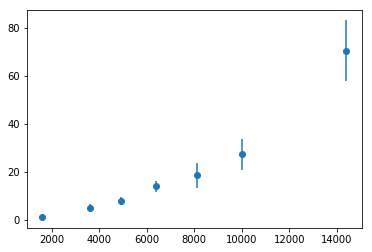

In [38]:
N = [d * d for d in dimensions]
plt.errorbar(N, taxis, yerr=terror, xerr=None, linestyle='', marker='o')
plt.plot(N, 0.00051*N*N)

In [117]:
atimes[90]

array([29.01748872, 27.3591187 , 27.69323993, 28.91812873, 28.17731285,
       27.34522104, 27.37522101, 27.83267307, 27.49466205, 29.84336925])

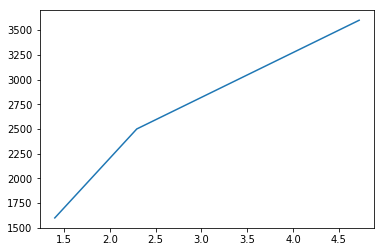